| **Chapter**               | 9:  Agent-based models                           |
|---------------------------|--------------------------------------------------|
| **Computational Note**    | 9.1: Using Mesa                                  |
|                           | 9.2: Initialising the model                      |
|                           | 9.3: Using enumerations to define states         |
|                           | 9.4: Creating the `Agent` blueprint              |
|                           | 9.5: Probabilistic steps in ABMs                 |
|                           | 9.6: Creating the infectious process             |
|                           | 9.7: Networks in Mesa                            |
|                           | 9.8: Activations in Mesa                         |
|                           | 9.9: The `Model` class and parametrising the ABM |
|                           | 9.10: Collection and export from ABMs            |
|                           | 9.11: Creating seed populations                  |
|                           | 9.12: Iterative running of ABMs                  |
| **Package prerequisites** | [Mesa](http://mesa.readthedocs.io)               |

# Agent-based SIR model


In [14]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batchrunner
from matplotlib import pyplot as plt
from matplotlib import colors as clrs
import networkx as nx
import json
from scipy import stats
import enum
from matplotlib.lines import Line2D


COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p mesa

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

mesa: 0.9.0

matplotlib: 3.5.2
json      : 2.0.9
scipy     : 1.8.1
mesa      : 0.9.0
networkx  : 2.8.4
pandas    : 1.4.2
numpy     : 1.22.4



In [3]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2
    DECEASED = 3

In [4]:
class Person(Agent):
    def __init__(self, uid, model):
        super().__init__(uid, model)
        
        # Naive start
        self.state = State.SUSCEPTIBLE
        
    def contact_event(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbourhood = [agent for agent in self.model.grid.get_cell_list_contents(neighbourhood) 
                                                                            if agent.state is State.SUSCEPTIBLE]

        for neighbour in susceptible_neighbourhood:
            if self.state is State.INFECTED and np.random.rand() < model.beta:
                neighbour.state = State.INFECTED

    def status_update(self):        
        if self.state == State.INFECTED:
            if np.random.rand() < 1/self.model.recovery_period:
                if np.random.rand() < self.model.CFR:
                    self.state = State.DECEASED
                else:
                    self.state = State.RECOVERED

        if np.random.rand() < self.model.base_mortality_rate:
            self.state = State.DECEASED


    def step(self):
        self.status_update()

        if self.state is State.INFECTED:
            self.contact_event()
    

In [5]:
class NetworkInfectiousDiseaseModel(Model):

    def __init__(self, 
                 nodes=5000, 
                 mean_degree=12,
                 recovery_period=14,
                 beta=0.04,
                 CFR=0.05,
                 base_mortality_rate=0.000125,
                 I0=0.005):
                     
        self.N_agents = nodes
        self.recovery_period = recovery_period
        self.beta = beta
        self.CFR = CFR
        self.base_mortality_rate = base_mortality_rate

        self.graph = nx.erdos_renyi_graph(n=self.N_agents, p=mean_degree/self.N_agents)
        self.grid = NetworkGrid(self.graph)

        self.schedule = RandomActivation(self)
        self.running = True

        for idx, node in enumerate(self.graph.nodes()):
            agent = Person(uid=idx + 1, model=self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

            if np.random.rand() < I0:
                agent.state = State.INFECTED

        self.datacollector = DataCollector(agent_reporters={"State": "state"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def to_df(self):
        state_profile = self.datacollector.get_agent_vars_dataframe()
        output_df = pd.pivot_table(state_profile.reset_index(), 
                       index="Step", 
                       columns="State", 
                       aggfunc=np.size, 
                       fill_value=0)
        output_df.columns = [i.title() for i in State.__dict__.get("_member_names_")]
        return output_df

In [6]:
pop=1000
steps=120

model = NetworkInfectiousDiseaseModel(pop)

for i in range(steps):
    model.step()

model_results = model.to_df()

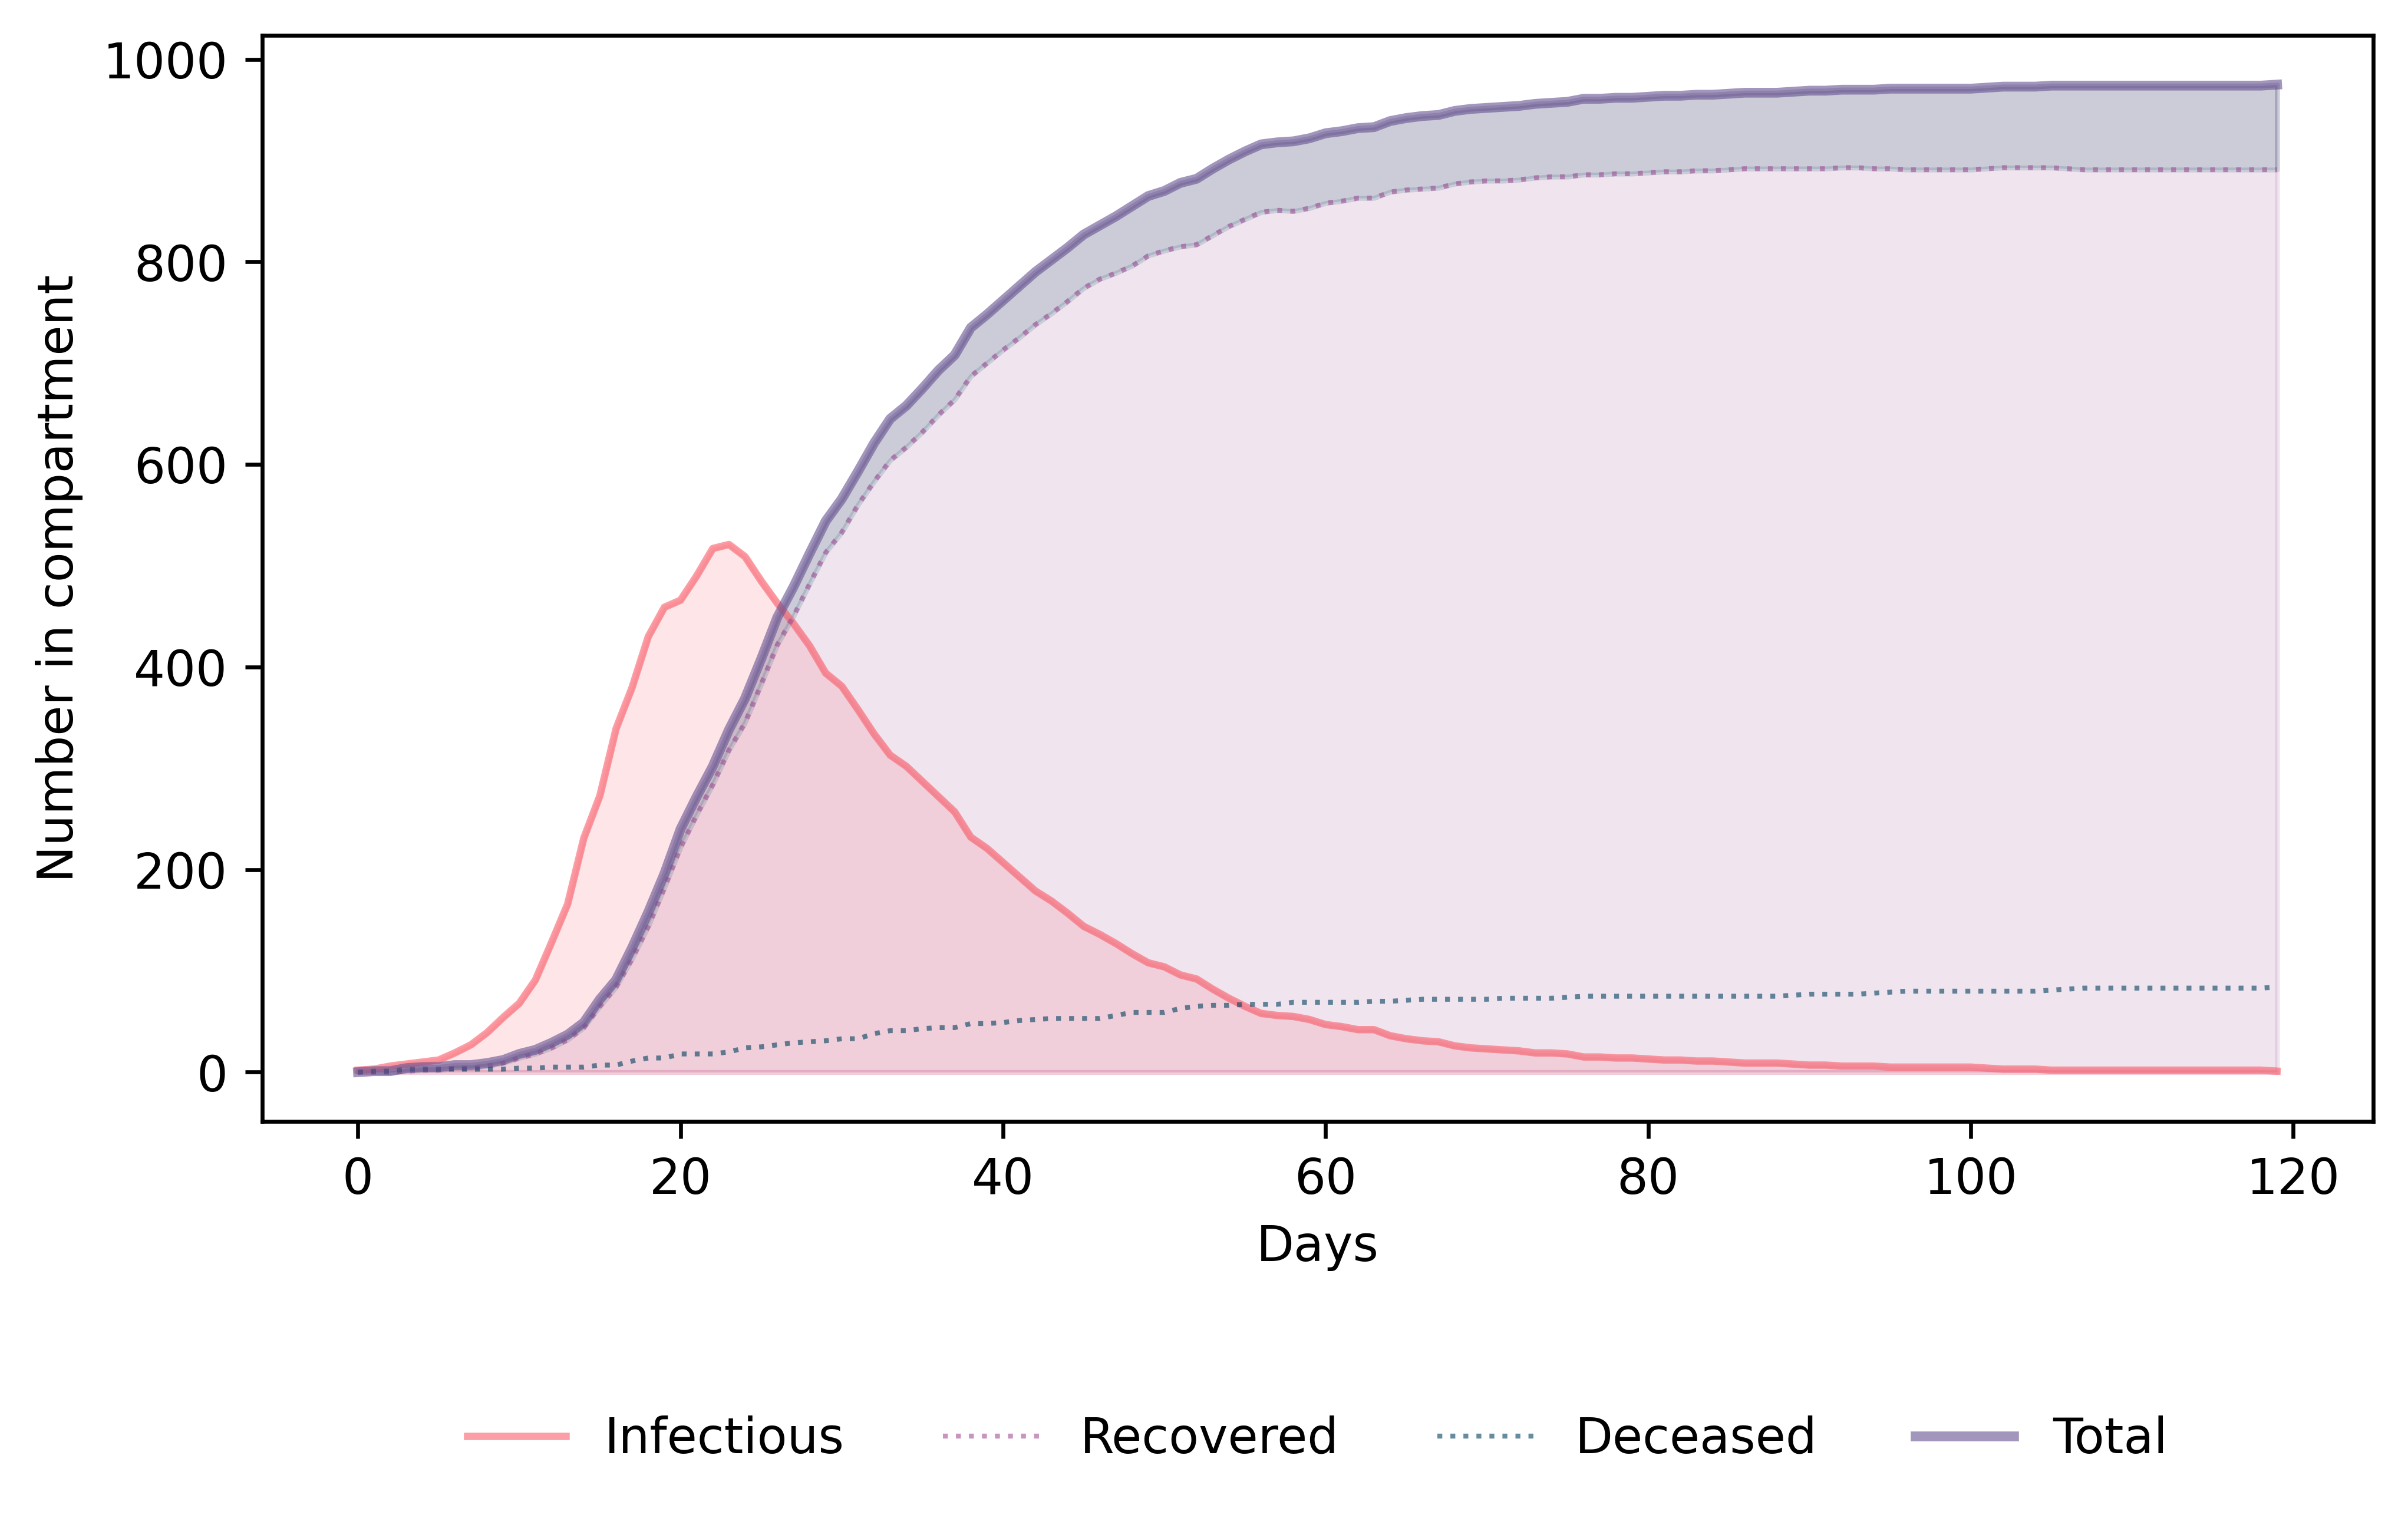

In [7]:
fig = plt.figure(facecolor="w", figsize=(8, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

# plt.plot(model_results.index, model_results.Susceptible, color=COLORS["S"], label="Susceptible")
ax.plot(model_results.index, model_results.Infected, color=COLORS["I"], alpha=0.6, label="Infectious")
ax.plot(model_results.index, model_results.Recovered, color=COLORS["R"], alpha=0.6, lw=1, linestyle=":", label="Recovered")
ax.plot(model_results.index, model_results.Deceased, color=COLORS["D"], alpha=0.6, lw=1, linestyle=":", label="Deceased")
ax.plot(model_results.index, model_results.Recovered + model_results.Deceased, color=COLORS["X"], alpha=0.6, lw=2, label="Total")

ax.fill_between(model_results.index, 0, model_results.Infected, color=COLORS["I"], alpha=0.15)
ax.fill_between(model_results.index, 0, model_results.Recovered + model_results.Deceased, color=COLORS["R"], alpha=0.15)
ax.fill_between(model_results.index, model_results.Recovered, model_results.Recovered + model_results.Deceased, color=COLORS["D"], alpha=0.15)


legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title="", bbox_to_anchor=(0.5, -0.355), loc="lower center", ncol=4, frameon=False)

ax.set_xlabel("Days")
ax.set_ylabel("Number in compartment")

fig.tight_layout(pad=5.0)
plt.savefig("SIRD_ABM_output.pdf")


In [8]:
br = batchrunner.FixedBatchRunner(NetworkInfectiousDiseaseModel,
                                  fixed_parameters={"nodes": 5000},
                                  iterations=36,
                                  max_steps=120,
                                  model_reporters={"vals": lambda m: m.datacollector},
                                  display_progress=True)

In [9]:
br.run_all()

36it [02:41,  4.50s/it]


In [10]:
results = [pd.pivot_table(i.get_agent_vars_dataframe().reset_index(), 
                    index="Step", 
                    columns="State", 
                    aggfunc=np.size, 
                    fill_value=0).rename(columns={0: "Susceptible",
                                                  1: "Infected",
                                                  2: "Recovered",
                                                  3: "Deceased"}).droplevel(0, axis=1) for i in br.get_model_vars_dataframe().vals]

In [11]:
means = pd.concat([each.stack() for each in results], axis=1).apply(lambda x: x.mean(), axis=1).unstack()
sds = pd.concat([each.stack() for each in results], axis=1).apply(lambda x: x.std(), axis=1).unstack()

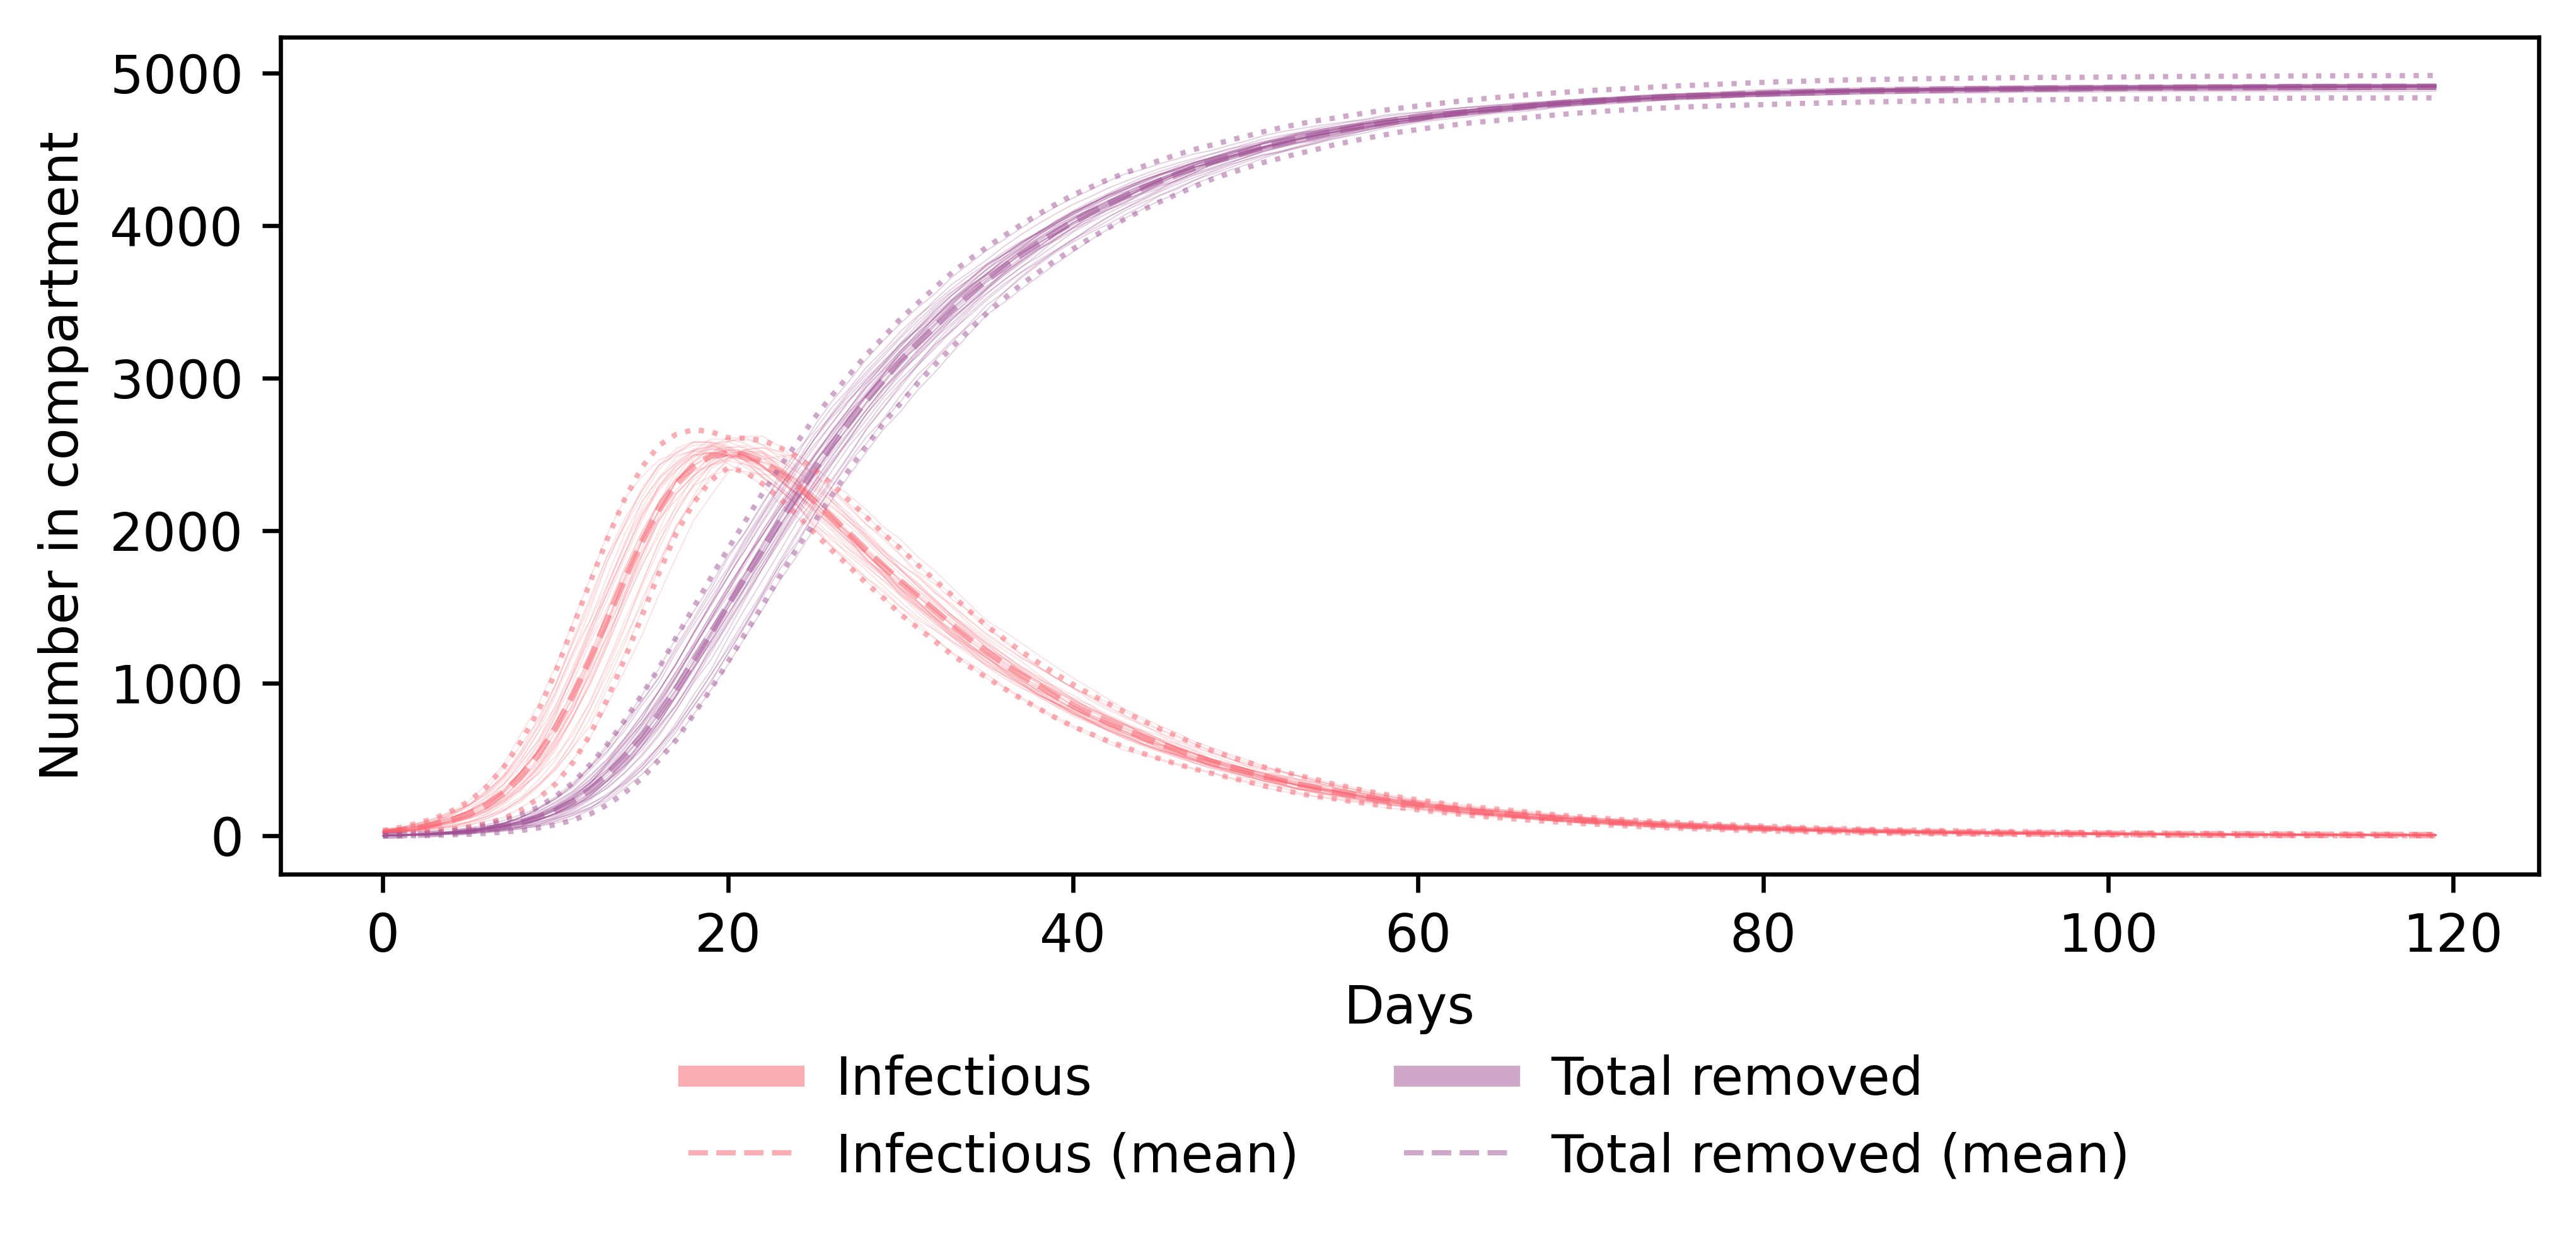

In [21]:
fig = plt.figure(facecolor="w", figsize=(8, 5.2), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

for idx, model_results in enumerate(results):

    ax.plot(model_results.index, model_results.Infected, color=COLORS["I"], alpha=0.2, lw=0.2, label="Infectious" if idx == 0 else "")
#    ax.plot(model_results.index, model_results.Recovered, color=COLORS["R"], alpha=0.2, lw=1, linestyle=":", label="Recovered" if idx == 0 else "")
#    ax.plot(model_results.index, model_results.Deceased, color=COLORS["D"], alpha=0.2, lw=1, linestyle=":", label="Deceased" if idx == 0 else "")
    ax.plot(model_results.index, model_results.Recovered + model_results.Deceased, color=COLORS["R"], alpha=0.3, lw=0.2, label=f"Total removed" if idx == 0 else "")

ax.plot(means.index, means.Infected, color=COLORS["I"], alpha=0.5, lw=1.25, linestyle="--", label="Infectious (mean)")
ax.plot(means.index, means.Recovered + means.Deceased, color=COLORS["R"], alpha=0.5, lw=1.25, linestyle="--", label="Total removed (mean)")
ax.plot(means.index, means.Infected + 1.96 * sds.Infected, color=COLORS["I"], alpha=0.5, lw=1, linestyle=":")
ax.plot(means.index, means.Infected - 1.96 * sds.Infected, color=COLORS["I"], alpha=0.5, lw=1, linestyle=":")
ax.plot(means.index, means.Recovered + means.Deceased + 1.96 * (sds.Recovered + sds.Deceased), color=COLORS["R"], alpha=0.5, lw=1, linestyle=":")
ax.plot(means.index, means.Recovered + means.Deceased - 1.96 * (sds.Recovered + sds.Deceased), color=COLORS["R"], alpha=0.5, lw=1, linestyle=":")

legend = ax.legend()
legend.get_frame().set_alpha(0.5)

legend_lines = [Line2D([0], [0], color=COLORS["I"], lw=4, alpha=0.5),
                Line2D([0], [0], color=COLORS["I"], lw=1, alpha=0.5, linestyle="dashed"),
                Line2D([0], [0], color=COLORS["R"], lw=4, alpha=0.5),
                Line2D([0], [0], color=COLORS["R"], lw=1, alpha=0.5, linestyle="dashed")]

ax.legend(legend_lines, ["Infectious", "Infectious (mean)", "Total removed", "Total removed (mean)"], title="", bbox_to_anchor=(0.5, -0.425), loc="lower center", ncol=2, frameon=False)


ax.set_xlabel("Days")
ax.set_ylabel("Number in compartment")

fig.tight_layout(pad=5.0)
plt.savefig("SIRD_ABM_output.pdf")